# Time series forecasting with Arima

Personal testing

## statsmodels

```
conda install -c conda-forge statsmodels
conda install statsmodels==0.12.1
```

In [98]:
import datetime
from datetime import date
import numpy as np
import pandas as pd
import statsmodels.api as sm

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 40 entries, 2021-01-05 to 2021-02-13
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Variable  40 non-null     float64
dtypes: float64(1)
memory usage: 640.0 bytes


<AxesSubplot:xlabel='Date'>

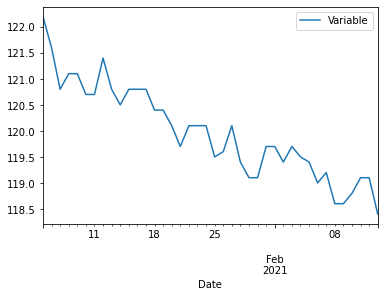

In [34]:
df = pd.read_csv('dataset.csv', parse_dates=['Date'], dayfirst=True, index_col=0)
df.info()
df.plot() # or 'Date','Variable'

# note: the index_col call above is important, if it's not there there's a world of relative pain
# to set the index to that column, and I think you have to delete the Date after you created an index with it:
# https://stackoverflow.com/questions/48473794/python-pandas-data-frame-format-index-issue

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

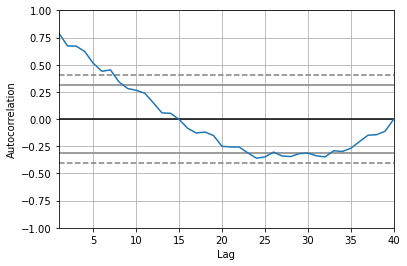

In [28]:
from matplotlib import pyplot
from pandas.plotting import autocorrelation_plot

# Autocorrelation plots are a commonly used tool for checking randomness in a data set.
# This randomness is ascertained by computing autocorrelation for data values at varying time lags. 
# autocorrelation_plot: https://pandas.pydata.org/docs/reference/api/pandas.plotting.autocorrelation_plot.html
# set_index because: https://stackoverflow.com/questions/46528520/pandas-typeerror-unsupported-operand-types-for-timedelta-and-float
autocorrelation_plot(df)  #df.set_index('Date')

In [35]:
from statsmodels.tsa.arima.model import ARIMA

# fit model
model = ARIMA(np.asarray(df), order=(5,1,0)) # what are these parameters?
model_fit = model.fit()

In [36]:
# summary of fit model
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   40
Model:                 ARIMA(5, 1, 0)   Log Likelihood                 -13.905
Date:                Sat, 13 Feb 2021   AIC                             39.810
Time:                        15:55:48   BIC                             49.792
Sample:                             0   HQIC                            43.392
                                 - 40                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2165      0.219     -0.988      0.323      -0.646       0.213
ar.L2         -0.3503      0.177     -1.979      0.048      -0.697      -0.003
ar.L3          0.0307      0.210      0.146      0.8

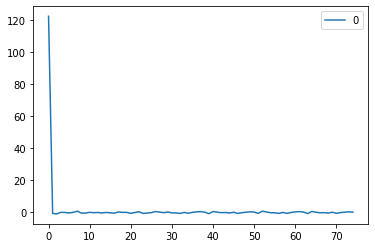

In [205]:
# line plot of residuals
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
pyplot.show()

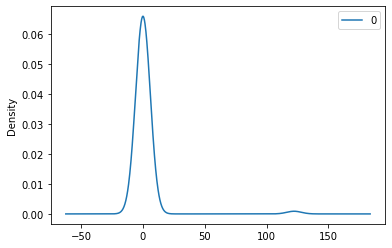

In [206]:
# density plot of residuals
residuals.plot(kind='kde')
pyplot.show()

# Next, we get a density plot of the residual error values, suggesting the errors are Gaussian
# (and apparently centered on zero or close to it)

In [207]:
# summary stats of residuals
print(residuals.describe())

# The distribution of the residual errors is displayed. The results show that indeed there is a bias in the
# prediction (a non-zero mean in the residuals). --- jota: is this bad? why is it relevant?

                0
count   75.000000
mean     1.588374
std     14.120364
min     -0.898721
25%     -0.329697
50%     -0.018076
75%      0.209797
max    122.200000


## Try doing predictions

In [208]:
# evaluate an ARIMA model using a walk-forward validation
from matplotlib import pyplot
from sklearn.metrics import mean_squared_error
from math import sqrt

# split into train and test sets
X = df.values
size = int(len(X) * 0.7)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()

In [209]:
# walk-forward validation
for t in range(len(test)):
	model = ARIMA(history, order=(2,1,2)) #5,1,0 -- 2,1,2)
	model_fit = model.fit()
	output = model_fit.forecast()
	yhat = output[0] # returns an array with 1 element, getting it
	predictions.append(yhat)
	expected = test[t]
	history.append(expected)
	print('predicted=%f, expected=%f' % (yhat, expected))

predicted=119.577974, expected=119.400000
predicted=119.737177, expected=119.700000
predicted=119.783158, expected=119.500000
predicted=119.148389, expected=119.400000
predicted=119.443408, expected=119.000000
predicted=119.333461, expected=119.200000
predicted=119.186912, expected=118.600000
predicted=118.317566, expected=118.600000
predicted=118.817752, expected=118.800000
predicted=119.004466, expected=119.100000
predicted=118.838482, expected=119.100000
predicted=118.908201, expected=118.400000


In [210]:
model_fit.predict(start=39, end=41)

# this should work but it doesn't. types?
# start_index = pd.datetime(2021, 2, 12)
# end_index = pd.datetime(2021, 2, 15)
# model_fit.predict('2021-2-12', '2021-2-14')

array([118.90820087, 119.16463749, 119.29491981])

In [211]:
model_fit.forecast(steps=3)

array([118.90820087, 119.16463749, 119.29491981])

https://stackoverflow.com/questions/45596492/statsmodels-arima-different-results-using-predict-and-forecast
*I would recommend going with forecast(step) or predict(start, end)*

Documentation:

- https://www.statsmodels.org/devel/generated/statsmodels.tsa.arima_model.ARIMAResults.forecast.html#statsmodels.tsa.arima_model.ARIMAResults.forecast - **forecast(steps) - Out-of-sample forecasts**, steps = The number of out of sample forecasts from the end of the sample.

- https://www.statsmodels.org/devel/generated/statsmodels.tsa.arima_model.ARIMAResults.predict.html#statsmodels.tsa.arima_model.ARIMAResults.predict - **predict(start, end) - ARIMA model in-sample and out-of-sample prediction**
    - start = Zero-indexed observation number at which to start forecasting, ie., the first forecast is start. Can also be a date string to parse or a datetime type; end = Zero-indexed observation number at which to end forecasting, ie., the first forecast is start. Can also be a date string to parse or a datetime type. However, if the dates index does not have a fixed frequency, end must be an integer index if you want out of sample prediction.

In [212]:
model_fit.forecast(5)

array([118.90820087, 119.16463749, 119.29491981, 119.00794192,
       118.94633319])

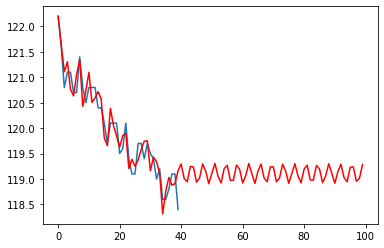

In [213]:
model_fit.predict(start=1, end=100)

pyplot.plot(X)
pyplot.plot(model_fit.predict(start=1, end=100, typ='levels'), color='red') # adding , typ='levels' doesn't change anything
pyplot.show()

In [204]:
# evaluate forecasts
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)

ValueError: Found input variables with inconsistent numbers of samples: [12, 48]

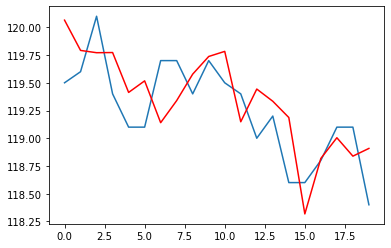

In [132]:
# plot forecasts against actual outcomes
# expected values - blue
# predictions - red
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()

## Hyperparameter tuning

In [99]:
import warnings
warnings.filterwarnings("ignore")

In [103]:
# evaluate an ARIMA model for a given order (p,d,q)
def evaluate_arima_model(X, arima_order):
	# prepare training dataset
	train_size = int(len(X) * 0.66)
	train, test = X[0:train_size], X[train_size:]
	history = [x for x in train]
	# make predictions
	predictions = list()
	for t in range(len(test)):
		model = ARIMA(history, order=arima_order)
		model_fit = model.fit()
		yhat = model_fit.forecast()[0]
		predictions.append(yhat)
		history.append(test[t])
	# calculate out of sample error
	rmse = sqrt(mean_squared_error(test, predictions))
	return rmse

In [104]:
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
	dataset = dataset.astype('float32')
	best_score, best_cfg = float("inf"), None
	for p in p_values:
		for d in d_values:
			for q in q_values:
				order = (p,d,q)
				try:
					mse = evaluate_arima_model(dataset, order)
					if mse < best_score:
						best_score, best_cfg = mse, order
					print('ARIMA%s MSE=%.3f' % (order,mse))
				except:
					continue
	print('Best ARIMA%s MSE=%.3f' % (best_cfg, best_score))

The parameters of the ARIMA model are defined as follows:

- p: The number of lag observations included in the model, also called the lag order.
- d: The number of times that the raw observations are differenced, also called the degree of differencing.
- q: The size of the moving average window, also called the order of moving average.

In [109]:
# evaluate parameters
p_values = [0, 1, 2, 4, 6, 8, 10]
d_values = range(0, 3)
q_values = range(0, 3)
warnings.filterwarnings("ignore")
evaluate_models(df.values, p_values, d_values, q_values)

ARIMA(0, 0, 0) MSE=1.120
ARIMA(0, 0, 1) MSE=0.716
ARIMA(0, 0, 2) MSE=0.506
ARIMA(0, 0, 3) MSE=0.586
ARIMA(0, 0, 4) MSE=0.598
ARIMA(0, 0, 5) MSE=0.423
ARIMA(0, 0, 6) MSE=0.417
ARIMA(0, 1, 0) MSE=0.356
ARIMA(0, 1, 1) MSE=0.348
ARIMA(0, 1, 2) MSE=0.362
ARIMA(0, 1, 3) MSE=0.408
ARIMA(0, 1, 4) MSE=0.400
ARIMA(0, 1, 5) MSE=0.440
ARIMA(0, 1, 6) MSE=0.415
ARIMA(0, 2, 0) MSE=0.501
ARIMA(0, 2, 1) MSE=0.363
ARIMA(0, 2, 2) MSE=0.368
ARIMA(0, 2, 3) MSE=0.346
ARIMA(0, 2, 4) MSE=0.382
ARIMA(0, 2, 5) MSE=0.404
ARIMA(0, 3, 0) MSE=0.819
ARIMA(0, 3, 1) MSE=0.510
ARIMA(0, 3, 2) MSE=0.417
ARIMA(0, 3, 3) MSE=0.387
ARIMA(0, 3, 4) MSE=0.494
ARIMA(0, 3, 5) MSE=0.467
ARIMA(0, 4, 0) MSE=1.492
ARIMA(0, 4, 1) MSE=0.833
ARIMA(0, 4, 2) MSE=0.542
ARIMA(0, 4, 3) MSE=0.490
ARIMA(0, 4, 4) MSE=0.490
ARIMA(0, 4, 5) MSE=0.542
ARIMA(0, 5, 0) MSE=2.877
ARIMA(0, 5, 1) MSE=1.518
ARIMA(0, 5, 2) MSE=0.865
ARIMA(0, 5, 3) MSE=0.569
ARIMA(0, 5, 4) MSE=0.555
ARIMA(0, 5, 5) MSE=0.839
ARIMA(0, 6, 0) MSE=5.796
ARIMA(0, 6, 1) MSE=2.926


In [107]:
#Best ARIMA(2, 1, 2) MSE=0.338

## Old code/not used

In [83]:
df['dayOfYear'] = [dt.timetuple().tm_yday for dt in df['Date']]

In [93]:
results = sm.OLS(df['dayOfYear'], df['Variable']).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:              dayOfYear   R-squared (uncentered):                   0.813
Model:                            OLS   Adj. R-squared (uncentered):              0.808
Method:                 Least Squares   F-statistic:                              169.5
Date:                Sat, 13 Feb 2021   Prob (F-statistic):                    8.88e-16
Time:                        14:31:34   Log-Likelihood:                         -155.18
No. Observations:                  40   AIC:                                      312.4
Df Residuals:                      39   BIC:                                      314.1
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Variable       0.2035      0.016     13.020      0.000       0.172       0.235
==============================================================================
Omnibus:                        8.338   Durbin-Watson:                   0.007
Prob(Omnibus):                  0.015   Jarque-Bera (JB):                2.397
Skew:                          -0.004   Prob(JB):                        0.302
Kurtosis:                       1.801   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""